In [19]:
#The following code is loosely based on
#https://github.com/Kulbear/stock-prediction/blob/master/stock-prediction.ipynb
import time
import math
import keras
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.layers import Concatenate
from keras.layers.recurrent import LSTM
import numpy as np
import pandas as pd
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt

In [20]:
def build_model(size, window, num_neurons, out_dim, D = [0.1, 0.1, 0.1]):
    #Create RNN
    RNN = Sequential()
    #First LSTM Layer
    RNN.add(LSTM(num_neurons[0], input_shape=(window, size), return_sequences = False, dropout = D[0]))
    RNN.add(Activation('tanh'))

    #First Dense Layer
    RNN.add(Dense(out_dim))
    RNN.add(Activation('tanh'))

    start = time.clock()
    #RNN.compile(loss='mean_squared_error', optimizer='adam')
    RNN.compile(loss='mean_absolute_percentage_error', optimizer='adam')
    print 'Compilation Time:', time.clock() - start
    return RNN

def normalize(data, alpha = 0.8, flip = True):
    #Normalize data to be between 0 and 1
    minimum = data.min()
    maximum = data.max()
    if flip:
        norm = alpha / (maximum - minimum) * (maximum - data)
    else:
        norm = alpha * (data - minimum) / (maximum - minimum)
    return norm, minimum, maximum

def unnormalize(data, minimum, maximum, alpha = 0.8):
    return maximum - data * (maximum - minimum) / alpha    

def preprocess_data(stock, sequence_length, forecast = 5, diff = 0, percent_train = 0.9):
    num_features = stock.shape[1]
    sequence_length += 1
    
    #Create array of windows
    result = np.zeros((len(stock) - sequence_length - forecast, sequence_length, num_features))
    for i in range(len(result)):
        result[i] = (stock[i:i + sequence_length])

    #Use certain percentage of the data for training
    cutoff = int(round(percent_train * len(result)))
    #cutoff = 810
       
    #y data is the last row of each window, X data is all other rows
    X_train = result[:cutoff-np.max([diff,0]),:-1,:]
    if diff > 0:
        X_test = result[cutoff-diff:-diff,:-1,:]
        y_train = result[diff:cutoff,-1,:]
    else:
        X_test = result[cutoff:,:-1,:]
        y_train = result[:cutoff,-1,:]
    y_test = result[cutoff:,-1,:]
    
    y_train = np.zeros((len(X_train),forecast))
    y_test = np.zeros((len(X_test),forecast))
    
    for i in range(len(y_train)):
        y_train[i] = stock[window+i:window+i+forecast,0]
    for i in range(len(y_test)):
        y_test[i] = stock[window+len(y_train)+i:window+len(y_train)+i+forecast,0]

    return [X_train, y_train, X_test, y_test]

In [21]:
data = np.loadtxt('DailyStocksBig.dat')
data, d1, d2 = normalize(data)

google = np.loadtxt('Google.dat')[:,:4]
google, g1, g2 = normalize(google)

apple = np.loadtxt('Apple.dat')[:,:4]
apple, a1, a2 = normalize(apple)

In [22]:
model = load_model('RNN_Model_Best.h5')

In [23]:
window = 15
X_train, y_train, X_test, y_test = preprocess_data(data, window, percent_train = 1, forecast = 5)
google_train, ygoogletrain, _, _ = preprocess_data(google, window, percent_train = 1, forecast = 5)
apple_train, _, _, _ = preprocess_data(apple, window, percent_train = 1, forecast = 5)

print "X_train:", X_train.shape
print "y_train:", y_train.shape
print "X_test:", X_test.shape
print "y_test:", y_test.shape

X_train: (19979, 15, 4)
y_train: (19979, 5)
X_test: (0, 15, 4)
y_test: (0, 5)


In [24]:
r = 64
num_neurons = [r]
num_inputs = X_train.shape[-1]
num_outputs = y_train.shape[-1]
model = build_model(num_inputs, window, num_neurons, num_outputs)

Compilation Time: 0.036629


In [25]:
start = time.clock()
hist = model.fit(
    X_train,
    y_train,
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    verbose=0)
print time.clock() - start

model.save('RNN_Model.h5')

trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.6f MAPE (%.6f MAPE)' % (trainScore, math.sqrt(trainScore)))

870.411106
Train Score: 11.213320 MAPE (3.348630 MAPE)


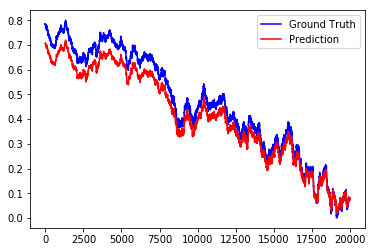

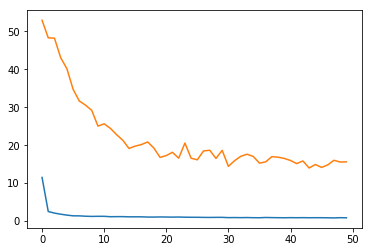

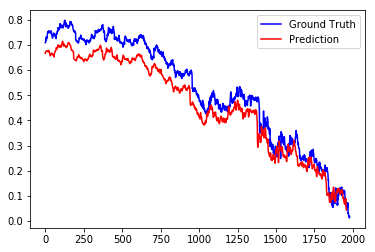

In [28]:
alpha = model.predict(X_train)[:,0]
plt.plot(y_train[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
#plt.plot(alpha[:,-1], 'g', label='Forecast')
#plt.plot(alpha - y_test[:,0,np.newaxis], label='Difference')
plt.legend(loc='best')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.show()

alpha = model.predict(google_train)[:,-1]
plt.plot(google[:,0], 'b', label='Ground Truth')
plt.plot(alpha, 'r', label='Prediction')
plt.legend(loc='best')
plt.show()

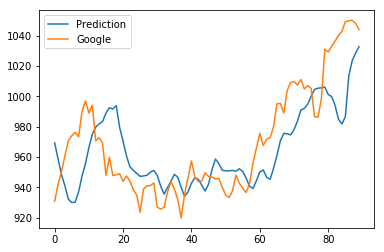

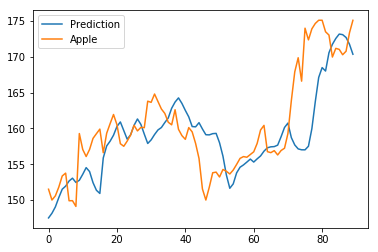

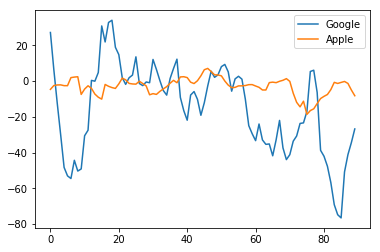

In [31]:
plt.plot(unnormalize(model.predict(google_train)[-90:,0],g1,g2), label = 'Prediction')
plt.plot(unnormalize(google,g1,g2)[-90:,0], label = 'Google')
plt.legend()
plt.show()

plt.plot(unnormalize(model.predict(apple_train)[-90:,0],a1,a2), label = 'Prediction')
plt.plot(unnormalize(apple,a1,a2)[-90:,0], label = 'Apple')
plt.legend()
plt.show()
plt.plot(unnormalize(model.predict(google_train)[-90:,-1],g1,g2) 
         - unnormalize(google,g1,g2)[-90:,0], label = 'Google')
plt.plot(unnormalize(model.predict(apple_train)[-90:,-1],a1,a2) 
         - unnormalize(apple,a1,a2)[-90:,0], label = 'Apple')
plt.legend()
plt.show()

In [32]:
#np.savetxt('Predictions.dat', np.vstack((
#    np.array(range(90)) - 90,
#    unnormalize(google,g1,g2)[-90:,0],
#    unnormalize(model.predict(google_train)[-90:,0],g1,g2),
#    unnormalize(apple,a1,a2)[-90:,0],
#    unnormalize(model.predict(apple_train)[-90:,0],a1,a2)
#)).T)